In [1]:
import numpy as np
import cv2

## Automatic Cartridge Masking

Hassan Gaber

email: hassansameh90@gmail.com

### Problem

Given an image of the interior of a cartidge case, in this case a 9mm cartridge, particular image features need to be masked and colored for firearm recognition. Currently, the image masking/coloring is done manually but needs to be automated. In this notebook, I will automate this image masking on the given example and attempt to apply it to other images of 9mm cartiges.

I will attempt to approach this problem first using image processing techniques, then using deep learning for image segmentation. **Each step in the algorithm is represented by a function in the notebook**

The main objective of the automatic masking algorithm is to apply image segmentation techniques to the input but also apply necessary transformations that make the image edges as discriminitive as possible to simplify the process in the segmentation step.

### 1 Pre-processing

In this step, the objective is to make the image edges as discriminitive as possible such that images edges are clearly visible in all regions and depths of the image.

In [2]:
import matplotlib.pyplot as plt

In [3]:
REF_PTH='data/asset.png'
TARGET_PTH='data/target.png'

In [4]:
def scale_image(image: np.ndarray, scale_p: int = 60) -> np.ndarray:
  """
  Scale image by percent of original size
  """
  width = int(image.shape[1] * scale_p/100)
  height = int(image.shape[0] * scale_p/100)
  dim: tuple = (width, height)
  print(f"Scaled from {image.shape[:2]} to {dim}")
  resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return resized

In [5]:
def rgb_to_grayscale(image: np.ndarray) -> np.ndarray:
  """
  This function calculates the average of the pixles over the
  color axis (which in this case represents the argument axis=2).
  """
  return np.average(image, axis=2)

Using Gaussian smoothing allows any noise, in this case cracks in the case image, to be suppressed and the more continuous details of the image to be amplified.

In [6]:
def gaussian_smoothing(image: np.ndarray, kernel_dim: int, std: float = -1.0) -> np.ndarray:
  """
  Applies Gaussian blurring given a kernel size
  """
  # creating the 1D kernel, only one dimension is needed since it's square
  k = cv2.getGaussianKernel(kernel_dim, std)

  # applying the square kernel (kernel_dim x kernel_dim)
  # ddepth = -1 means that the result keeps the same scale
  blurred_image = cv2.sepFilter2D(image, ddepth=-1, kernelX=k, kernelY=k)
  return blurred_image

Sobel image gradients amplify the regions in the image where the first derivative of the pixel magnitude (calculated by sptial frequency) is large. What this means is that regions in the image where there is a significant change in the pixel value will be more visible; showing the edges more

In [7]:
def sobel_image_gradient(image: np.ndarray) -> tuple:
  """
  Finds image gradient in X and Y direction using a Sobel filter
  """
  sobelx = cv2.Sobel(image, ddepth=-1, dx=1, dy=0, ksize=5)
  sobely = cv2.Sobel(image, ddepth=-1, dx=0, dy=1, ksize=5)
  return sobelx, sobely

In [8]:
def edge_magnitude(Gx: np.ndarray, Gy: np.ndarray) -> np.ndarray:
  """Given dx and dy, the magnitude of the matrix is sqrt(dx^2 + dy^2)"""
  return np.sqrt(Gx**2 * Gy**2)

def edge_orientation(Gx: np.ndarray, Gy: np.ndarray) -> np.ndarray:
  """
  - arctan2 is a numpy function extending the domain to [-pi, pi]
  - it takes the element-wise arctangent of the matrix
  Gx/Gy and returns it in radians, can comment out the rest of
  the line for degrees
  """
  theta = np.arctan2(Gx, Gy) # * (180/np.pi)
  return theta

Image is read, rescaled, and converted to gray scale

Scaled from (770, 750) to (375, 385)


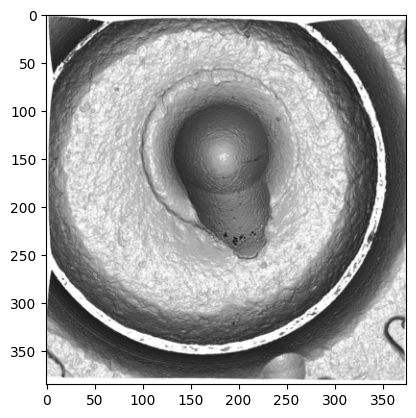

In [20]:
# reference image
image = cv2.imread(REF_PTH)
image = scale_image(image,50)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = rgb_to_grayscale(image) # squeezing the dimensions
plt.imshow(image,cmap='gray')

Applying image dilation to enlarge features of interest in the image; the cartridge breach face impression and firing pin

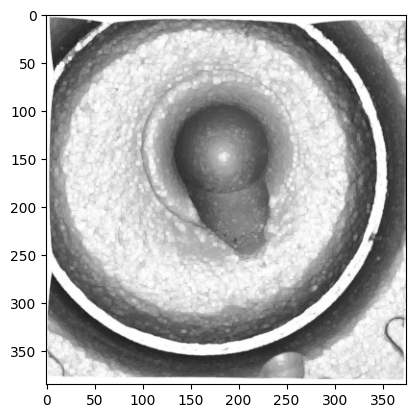

In [21]:
dilation_kernel = np.ones((3,3), np.uint8)
dilated_image = cv2.dilate(image, dilation_kernel, iterations=1)
plt.imshow(dilated_image,cmap='gray')

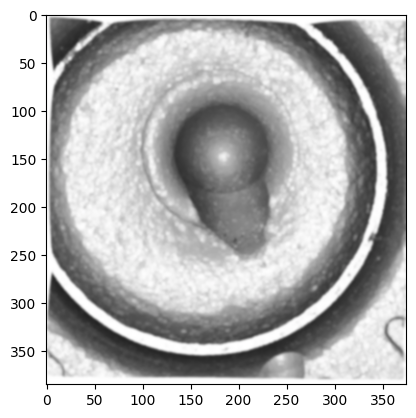

In [22]:
image_blurred = gaussian_smoothing(dilated_image, kernel_dim=5)
plt.imshow(image_blurred,cmap='gray')

Extracting the X and Y direction intensity derviatives; where the pixel intensity change is the largest

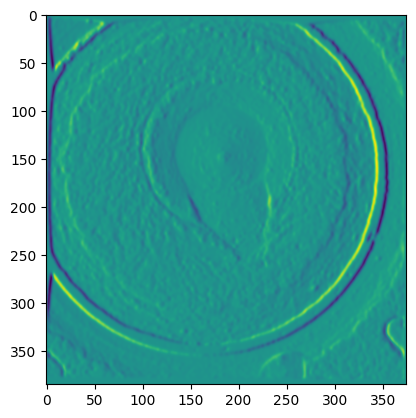

In [15]:
image_dx, image_dy = sobel_image_gradient(image_blurred)
plt.imshow(image_dx)

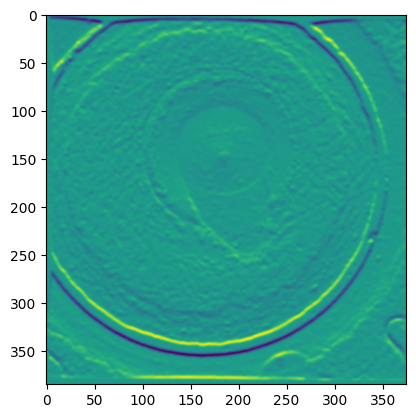

In [16]:
plt.imshow(image_dy)

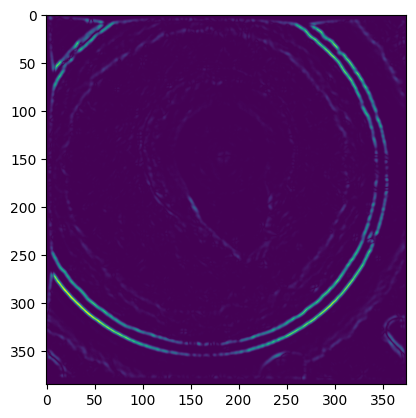

In [17]:
image_em = edge_magnitude(image_dx,image_dy)
plt.imshow(image_em)

Scaled from (490, 488) to (244, 245)


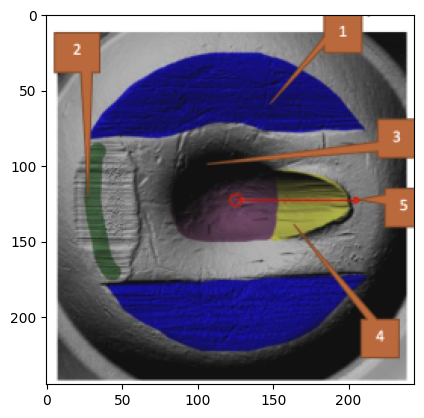

In [ ]:
# target image
# Order of masking: 
# 1. The breech-face impression (red) 
# 2. The aperture shear (green) 
# 3. The firing pin impression (purple) 
# 4. The firing pin drag (light blue)  
# 5. The direction of the firing pin drag (blue arrow)
target=cv2.imread(TARGET_PTH)
target=scale_image(target,50)
plt.imshow(target)

### 2 Segmentation

In this step, a model-based approach will be applied to segment the regions in the image

In [18]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

In [23]:
# segment anything model: vision transformer
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
# sam.cuda()
mask_generator = SamAutomaticMaskGenerator(model=sam)
masks = mask_generator.generate(image_blurred)

In [24]:
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

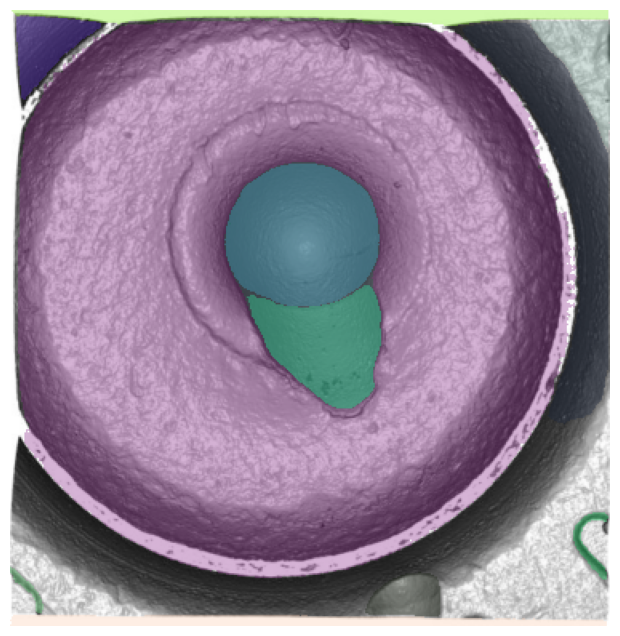

In [25]:
# Display the segmented image
plt.figure(figsize=(8, 8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()